In [1]:
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from collections import Counter
from collections import defaultdict
sys.path.append('examples/lore/')

from util import record2str, neuclidean
from datamanager import prepare_adult_dataset, prepare_dataset

from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df1=pd.read_csv('DATASETS/NumericalSummaryOnly/Ravdess_TRAIN_transformed.csv')
df2=pd.read_csv('DATASETS/NumericalSummaryOnly/Ravdess_TEST_transformed.csv')
df=pd.concat([df1,df2],ignore_index=True)

sex_mapper = {0:"Male", 1:"Female"}
df["sex"] = df["sex"].replace(sex_mapper)
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,sum,max,q25,...,stft_sum_w4,stft_std_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4
0,0,1,0,1,1,1,Male,0.328567,-0.391762,0.342857,...,0.135483,-1.096766,-0.402429,1.421380,0.948188,0.831973,0.536448,0.0,10.826275,-2.710136
1,0,1,0,1,2,1,Male,0.272964,-0.346159,0.342857,...,-0.196060,-1.013205,1.702463,1.092210,0.597843,0.441189,0.253557,0.0,0.064887,0.425032
2,0,1,0,0,1,1,Male,0.337392,-0.284007,0.371429,...,-0.307833,-0.716367,-0.402429,0.899688,0.680414,0.652634,0.569396,0.0,3.519767,-1.290314
3,0,1,0,0,2,1,Male,0.318693,-0.258631,0.342857,...,-0.607848,-0.803778,1.346476,0.835496,0.532143,0.515441,0.405521,0.0,0.218601,-0.015380
4,0,2,0,1,1,1,Male,0.315162,-0.478371,0.342857,...,0.145139,-0.863050,1.018057,0.935801,0.644804,0.549313,0.296205,0.0,1.260594,-0.448574


In [3]:
class_name="sex"
columns2remove = ["emotion", "vocal_channel","statement", "repetition", "actor","emotional_intensity"]

df.drop(columns2remove, inplace=True, axis=1)
df.head()

,sex,sum,max,q25,q50,q75,kur,skew,lag1_sum,lag1_q25,...,stft_sum_w4,stft_std_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4
0,Male,0.328567,-0.391762,0.342857,0.0,-0.382979,0.694009,1.632274,0.0,0.5,...,0.135483,-1.096766,-0.402429,1.421380,0.948188,0.831973,0.536448,0.0,10.826275,-2.710136
1,Male,0.272964,-0.346159,0.342857,0.0,-0.382979,0.888623,1.799483,0.0,0.5,...,-0.196060,-1.013205,1.702463,1.092210,0.597843,0.441189,0.253557,0.0,0.064887,0.425032
2,Male,0.337392,-0.284007,0.371429,0.0,-0.382979,0.961516,2.258762,-1.0,0.5,...,-0.307833,-0.716367,-0.402429,0.899688,0.680414,0.652634,0.569396,0.0,3.519767,-1.290314
3,Male,0.318693,-0.258631,0.342857,0.0,-0.382979,1.599962,3.167558,-0.5,0.5,...,-0.607848,-0.803778,1.346476,0.835496,0.532143,0.515441,0.405521,0.0,0.218601,-0.015380
4,Male,0.315162,-0.478371,0.342857,0.0,-0.382979,0.455058,1.144307,-0.5,0.5,...,0.145139,-0.863050,1.018057,0.935801,0.644804,0.549313,0.296205,0.0,1.260594,-0.448574


In [4]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res

In [5]:
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(df[feature_names].values, df[class_name].values, 
                                                    test_size=test_size,
                                                    stratify=df[class_name].values)

_, K, _, _ = train_test_split(rdf[real_feature_names].values, rdf[class_name].values, 
                              test_size=test_size,
                              stratify=df[class_name].values)

# Neural Network

In [6]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver="sgd", validation_fraction=0.35, early_stopping=True)

model=clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9225543478260869
F1-score [0.9215956  0.92348993]
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       361
           1       0.93      0.92      0.92       375

    accuracy                           0.92       736
   macro avg       0.92      0.92      0.92       736
weighted avg       0.92      0.92      0.92       736



# Local Explanations

### Select a record to explain

In [7]:
i2e = 98
x = X_test[i2e]

In [8]:
def bb_predict(X):
    return clf.predict(X)

def bb_predict_proba(X):
    return clf.predict_proba(X)

In [9]:
bb_outcome = bb_predict(x.reshape(1, -1))[0]
bb_outcome_str = class_values[bb_outcome]

print('bb(x) = { %s }' % bb_outcome_str)
print('')

bb(x) = { Female }



## LIME

https://github.com/marcotcr/lime

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
lime_explainer = LimeTabularExplainer(X_test, 
                                      feature_names=feature_names,
                                      class_names=[str(v) for v in class_values], discretize_continuous=False)

In [ ]:
exp = lime_explainer.explain_instance(x, bb_predict_proba)

In [ ]:
exp.local_exp

In [ ]:
exp.show_in_notebook()

## SHAP

In [19]:
import shap
shap.initjs()

In [22]:
f = lambda x: bb_predict_proba(x)[:, 1]
med = np.median(X_train, axis=0).reshape((1, X_train.shape[1]))

explainer = shap.Explainer(f, med,feature_names=feature_names)
shap_values = explainer(X_test,max_evals=600)

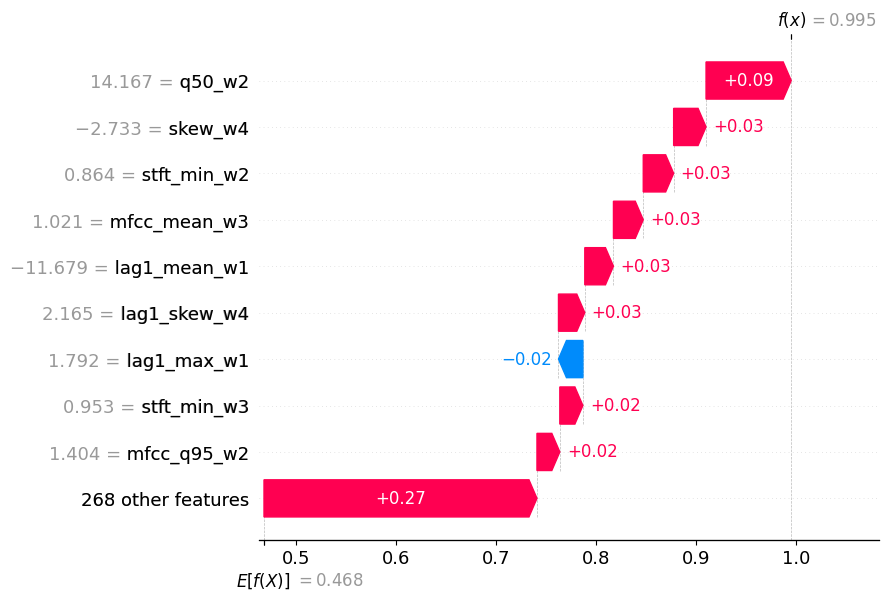

In [26]:
shap.plots.waterfall(shap_values[9])

In [24]:
shap.force_plot(shap_values[9])

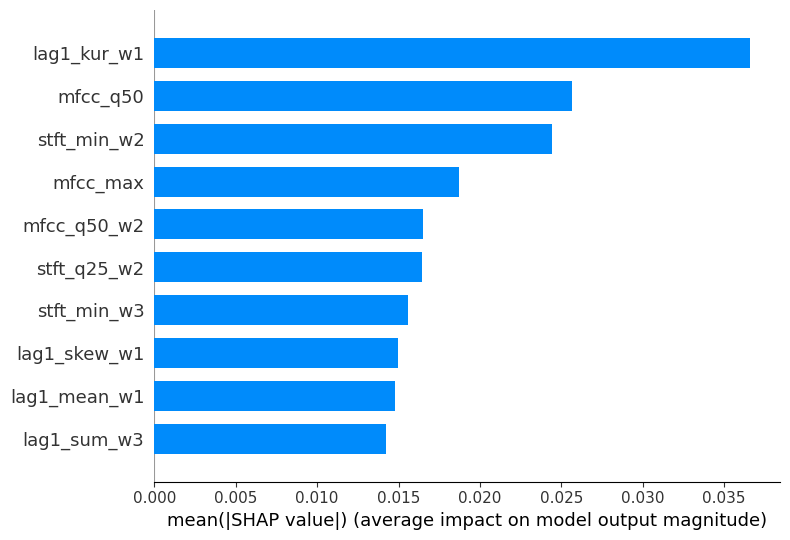

In [25]:
shap.summary_plot(shap_values, X_test, feature_names=feature_names,max_display=10,plot_type="bar")

## LORE

In [ ]:
from lorem import LOREM

In [ ]:
lore_explainer = LOREM(K, bb_predict, feature_names, class_name, class_values, numeric_columns, features_map,
                       neigh_type='geneticp', categorical_use_prob=True, continuous_fun_estimation=False, 
                       size=1000, ocr=0.1, random_state=42, ngen=10, bb_predict_proba=bb_predict_proba, 
                       verbose=True)

In [ ]:
exp = lore_explainer.explain_instance(x, samples=300, use_weights=True, metric=neuclidean)

In [ ]:
print(exp)

In [ ]:
x1 = x.copy()
x1[feature_names.index('lag1_q99_w2')] = 3

print('x1 = %s' % record2str(x1, feature_names, numeric_columns))
print('')

In [ ]:
bb_outcome = bb_predict(x1.reshape(1, -1))[0]
bb_outcome_str = class_values[bb_outcome]

print('bb(x) = { %s }' % bb_outcome_str)
print('')

In [ ]:
from sklearn.tree import plot_tree

In [ ]:
plt.figure(figsize=(14, 10))
plot_tree(exp.dt, 
          feature_names=feature_names, 
          class_names=['Male', 'Female'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

## DALEX

https://dalex.drwhy.ai/python-dalex-titanic.html

https://github.com/ModelOriented/DALEX

### Counterfactual Explanations

In [ ]:
import fatf.transparency.predictions.counterfactuals as fatf_cf

In [ ]:
# Create a Counterfactual Explainer
cf_explainer = fatf_cf.CounterfactualExplainer(
    model=clf,
    dataset=X_test,
    categorical_indices=[],
    default_numerical_step_size=1,
    max_counterfactual_length=1
)

In [ ]:
dp_1_cf_tuple = cf_explainer.explain_instance(x1)
dp_1_cfs, dp_1_cfs_distances, dp_1_cfs_predictions = dp_1_cf_tuple

In [ ]:
dp_1_cfs

In [ ]:
dp_1_cfs_text = fatf_cf.textualise_counterfactuals(
    x1,
    dp_1_cfs,
    instance_class=bb_outcome,
    counterfactuals_distances=dp_1_cfs_distances,
    counterfactuals_predictions=dp_1_cfs_predictions)
print(dp_1_cfs_text)